In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../')
from sentiment.nlp_utils import tagging_utils as tu
os.chdir('notebooks')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Get current tickers in US equities market
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

In [6]:
comments = pd.read_csv('../scraped_data/wsb_comments.csv')  # Read comments data
comments = comments[['id', 'body', 'score', 'created_utc']]  # Select relevant columns
comments = comments[comments['body'].str.len().between(20, 512)]  # Filter comments less than 20 characters
comments['created_utc'] = pd.to_datetime(comments['created_utc'], unit='s')

In [7]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3433365 entries, 0 to 4386256
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           object        
 1   body         object        
 2   score        int64         
 3   created_utc  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 131.0+ MB


In [8]:
comments = tu.apply_keywords_tags(comments, tickers, 'body')
comments = comments[comments['body_keywords'].astype(bool)]
comments.head()

100%|██████████| 3433365/3433365 [00:46<00:00, 73463.15it/s]


,id,body,score,created_utc,body_keywords
16,gav32x7,>AAPL $100 11/6 \n\nBan.,1,2020-11-02 03:32:12,[AAPL]
29,gav3578,And what if he still wants to marry her even t...,1,2020-11-02 03:32:51,[A]
33,gav3607,"This dude is COO for his mom's Etsy store, don...",1,2020-11-02 03:33:05,[COO]
71,gav3ax9,"Seemed to me as a solid DD, but 0 day to expir...",1,2020-11-02 03:34:30,[DD]
75,gav3bhy,"C'mon guys, Donald Trump doesn't just eat Big ...",2,2020-11-02 03:34:40,[C]


In [21]:
sentiment_tagger = tu.tagging_pipeline('sentiment-analysis', 'textattack/roberta-base-SST-2')
comments_samp = sentiment_tagger(comments.sample(100), 'body')

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


In [13]:
comments['sentiment_score'] = comments['body_sentiment'].apply(lambda x: int(x[0]['label'] == 'POSITIVE') * 2 - 1)

In [15]:
comments.head()

,id,body,score,created_utc,body_keywords,body_sentiment,sentiment_score
16,gav32x7,>AAPL $100 11/6 \n\nBan.,1,2020-11-02 03:32:12,[AAPL],"[{'label': 'POSITIVE', 'score': 0.500770330429...",1
29,gav3578,And what if he still wants to marry her even t...,1,2020-11-02 03:32:51,[A],"[{'label': 'POSITIVE', 'score': 0.500770330429...",1
33,gav3607,"This dude is COO for his mom's Etsy store, don...",1,2020-11-02 03:33:05,[COO],"[{'label': 'POSITIVE', 'score': 0.500770330429...",1
71,gav3ax9,"Seemed to me as a solid DD, but 0 day to expir...",1,2020-11-02 03:34:30,[DD],"[{'label': 'POSITIVE', 'score': 0.500770330429...",1
75,gav3bhy,"C'mon guys, Donald Trump doesn't just eat Big ...",2,2020-11-02 03:34:40,[C],"[{'label': 'POSITIVE', 'score': 0.500770330429...",1


In [14]:
big_comments = pd.read_csv('comments_sentiment.csv')

In [18]:
(big_comments.set_index('id')['sentiment_score'] - comments.set_index('id')['sentiment_score']).abs().sum() / 2

194612.0

In [40]:
comment.to_csv('comments_sentiment.csv')

In [30]:
out = tu.get_keywords_sentiment(comments, tickers, 'body', 'distilbert-base-uncased-finetuned-sst-2-english', summarize='count')
out.head()

  4%|▍         | 10734/248324 [10:41<3:56:32, 16.74it/s]


KeyboardInterrupt: 

In [29]:
comments['body_keywords'].apply(lambda x: np.unique(x).shape[0]).sum()

KeyError: 'body_keywords'

In [28]:
out.apply(lambda x: x[0] + x[1]).sum()

796

In [2]:
df = pd.read_csv('wsb_comments.csv')

In [3]:
df.dropna(subset=['id', 'created_utc', 'subreddit', 'body'], inplace=True)
df.drop_duplicates(subset=['id', 'subreddit'], inplace=True)

In [4]:
df = df[(df['body'] != '[removed]') & (df['body'] != '[deleted]')]
df['created_utc'] = df['created_utc'].astype('datetime64')

In [5]:
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9280021 entries, 0 to 9626570
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   created_utc   datetime64[ns]
 2   retrieved_on  object        
 3   subreddit     object        
 4   author        object        
 5   body          object        
dtypes: datetime64[ns](1), object(5)
memory usage: 495.6+ MB
None


,id,created_utc,retrieved_on,subreddit,author,body
0,fnqn6wg,2020-04-18 00:00:01,2020-04-18 01:11:17,wallstreetbets,Xall1996,How is this a DD? This is a TA and everybody k...
1,fnqn74u,2020-04-18 00:00:05,2020-04-18 01:11:20,wallstreetbets,kingfortheday772,People who use webull on here how much is it b...
2,fnqn73l,2020-04-18 00:00:05,2020-04-18 01:11:20,wallstreetbets,TechniCruller,If you want a winning REIT sector go data cent...
3,fnqn74e,2020-04-18 00:00:05,2020-04-18 01:11:20,wallstreetbets,MuchoMacho,9/11. airline industry
4,fnqn77v,2020-04-18 00:00:07,2020-04-18 01:11:21,wallstreetbets,nsrbigshot,4 now &gt;:)
...,...,...,...,...,...,...
9626566,gayaa4x,2020-11-02 23:59:47,2020-11-03 01:42:50,wallstreetbets,aRecycleAwayAccount,This is an option pricing bot. The latest opti...
9626567,gayaa93,2020-11-02 23:59:49,2020-11-03 01:42:51,wallstreetbets,Covid19KilledEpstein,Did you two start banging each other’s butts i...
9626568,gayaaep,2020-11-02 23:59:52,2020-11-03 01:42:53,wallstreetbets,Baconstripz69,No self promoting
9626569,gayaafj,2020-11-02 23:59:52,2020-11-03 01:42:53,wallstreetbets,Egg_Empty,What money are you actually making on it?


In [ ]:
df.groupby('author').apply(len).sort_values()[:-2]

In [2]:
import datatable as dt

In [ ]:
data = pd.concat(
    [
        pd.read_csv(file) for file in 
        ['full_present_comments.csv', '../scraped_data/pushshift/cleaned_comments/full_comments.csv']
    ]
)

In [ ]:
full_data = dt.rbind(
    dt.fread('full_present_comments.csv'),
    dt.fread('../scraped_data/pushshift/cleaned_comments/full_comments.csv')
)

In [4]:
present

,id,created_utc,retrieved_on,subreddit,author,body
,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,fnqn6wg,2020-04-18 00:00:01,2020-04-18 01:11:17,wallstreetbets,Xall1996,How is this a DD? This is a TA and everybody knows…
1,fnqn74u,2020-04-18 00:00:05,2020-04-18 01:11:20,wallstreetbets,kingfortheday772,People who use webull on here how much is it bette…
2,fnqn73l,2020-04-18 00:00:05,2020-04-18 01:11:20,wallstreetbets,TechniCruller,If you want a winning REIT sector go data center (…
3,fnqn74e,2020-04-18 00:00:05,2020-04-18 01:11:20,wallstreetbets,MuchoMacho,9/11. airline industry
4,fnqn77v,2020-04-18 00:00:07,2020-04-18 01:11:21,wallstreetbets,nsrbigshot,4 now &gt;:)
5,fnqn7dj,2020-04-18 00:00:09,2020-04-18 01:11:25,wallstreetbets,trele_morele,There's literally no case for bears when such an i…
6,fnqn7gd,2020-04-18 00:00:10,2020-04-18 01:11:25,wallstreetbets,mprostran,Good luck brother 🙌
7,fnqn7h2,2020-04-18 00:00:11,2020-04-18 01:11:25,wallstreetbets,WarrenBuffetsSon,LMFAO WHAT IS HE EVEN TALKING ABOUT THAT?
8,fnqn7ka,2020-04-18 00:00:12,2020-04-18 01:11:28,wallstreetbets,LeBronomatopoeia,As expected


In [2]:
foo = pd.read_csv('full_present_comments.csv')
foo['created_utc'] = foo['created_utc'].astype('datetime64')
foo['day'] = foo['created_utc'].dt.date

In [7]:
data = foo.groupby(['subreddit', 'day']).apply(len).reset_index()

In [25]:
data

,subreddit,day,len
0,investing,2020-04-18,4807
1,investing,2020-04-19,3715
2,investing,2020-04-20,5974
3,investing,2020-04-21,5597
4,investing,2020-04-22,3574
...,...,...,...
592,wallstreetbets,2020-10-29,50094
593,wallstreetbets,2020-10-30,50059
594,wallstreetbets,2020-10-31,20761
595,wallstreetbets,2020-11-01,19353


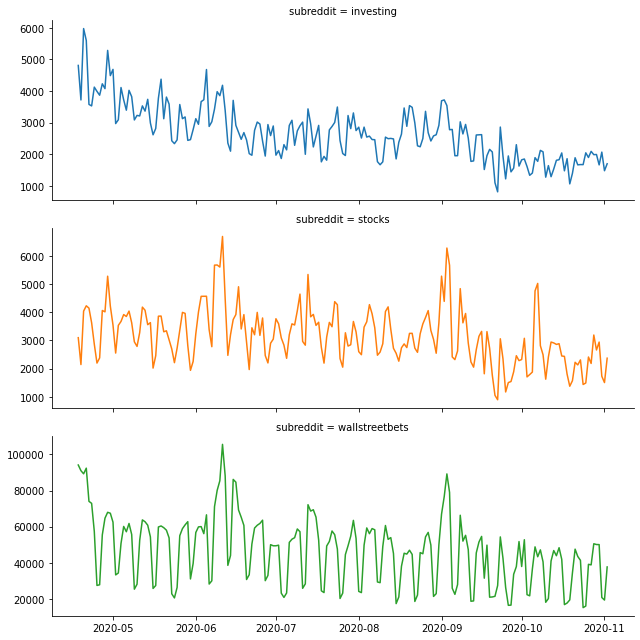

In [39]:
g = sns.FacetGrid(data=data, hue='subreddit', row='subreddit', aspect=3, sharey=False)
g.map_dataframe(sns.lineplot, x='day', y='len')